# 04-EEG-Based Game Rating Classification (PEGI & ESRB)

# Name Surname: Esra Aydın student ID: 211805079

In [1]:
import joblib
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge,  Ridge

In [2]:
from datetime import datetime
print("Date:", datetime.today().strftime('%Y-%m-%d'))

Date: 2025-04-20


In [3]:
file_path = r"C:\Users\esra\Downloads\ML_Midterm\04-EEG-Based Game Rating Classification (PEGI & ESRB).xlsx"
# Excel dosyasını oku
df = pd.read_excel(file_path)

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
check_df(df)  

##################### Shape #####################
(900, 2270)
##################### Types #####################
PEGI                                int64
ESRB                               object
RMS_50_EEG.AF3                    float64
MAX_50_EEG.AF3                    float64
MIN_50_EEG.AF3                    float64
                                   ...   
STD_200_POW.AF4.Gamma             float64
PTP_200_POW.AF4.Gamma             float64
Kurtosis_200_POW.AF4.Gamma        float64
ZeroCrossing_200_POW.AF4.Gamma    float64
CrestFactor_200_POW.AF4.Gamma     float64
Length: 2270, dtype: object
##################### Head #####################
   PEGI  ESRB  RMS_50_EEG.AF3  MAX_50_EEG.AF3  MIN_50_EEG.AF3  MA_50_EEG.AF3  \
0    12  teen        1.271920       -0.296349       -1.966410      -1.187020   
1    12  teen        1.260510        1.949350        0.417872       1.198790   
2    12  teen        1.639400        2.041750        1.315090       1.629100   
3    12  teen        1.452530

# Feature Engineering

In [32]:
dff = df.copy()
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
na_columns = missing_values_table(dff, na_name=True) 

                      n_miss  ratio
MIN_200_POW.O2.Theta      41   4.56
MAX_200_POW.O2.Theta      18   2.00
MA_200_POW.O2.Theta       12   1.33


In [34]:
selected_cols = ['MIN_200_POW.O2.Theta', 'MAX_200_POW.O2.Theta', 'MA_200_POW.O2.Theta']

#Apply incomplete filling methods
subset = dff[selected_cols]
imputation_methods = {}
# 2. KNN
knn_imputer = KNNImputer(n_neighbors=3)
imputation_methods['KNN Imputation (k=3)'] = pd.DataFrame(knn_imputer.fit_transform(subset), columns=selected_cols, index=dff.index)

# 3. Iterative
iterative_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
imputation_methods['Iterative Imputation'] = pd.DataFrame(iterative_imputer.fit_transform(subset), columns=selected_cols, index=dff.index)

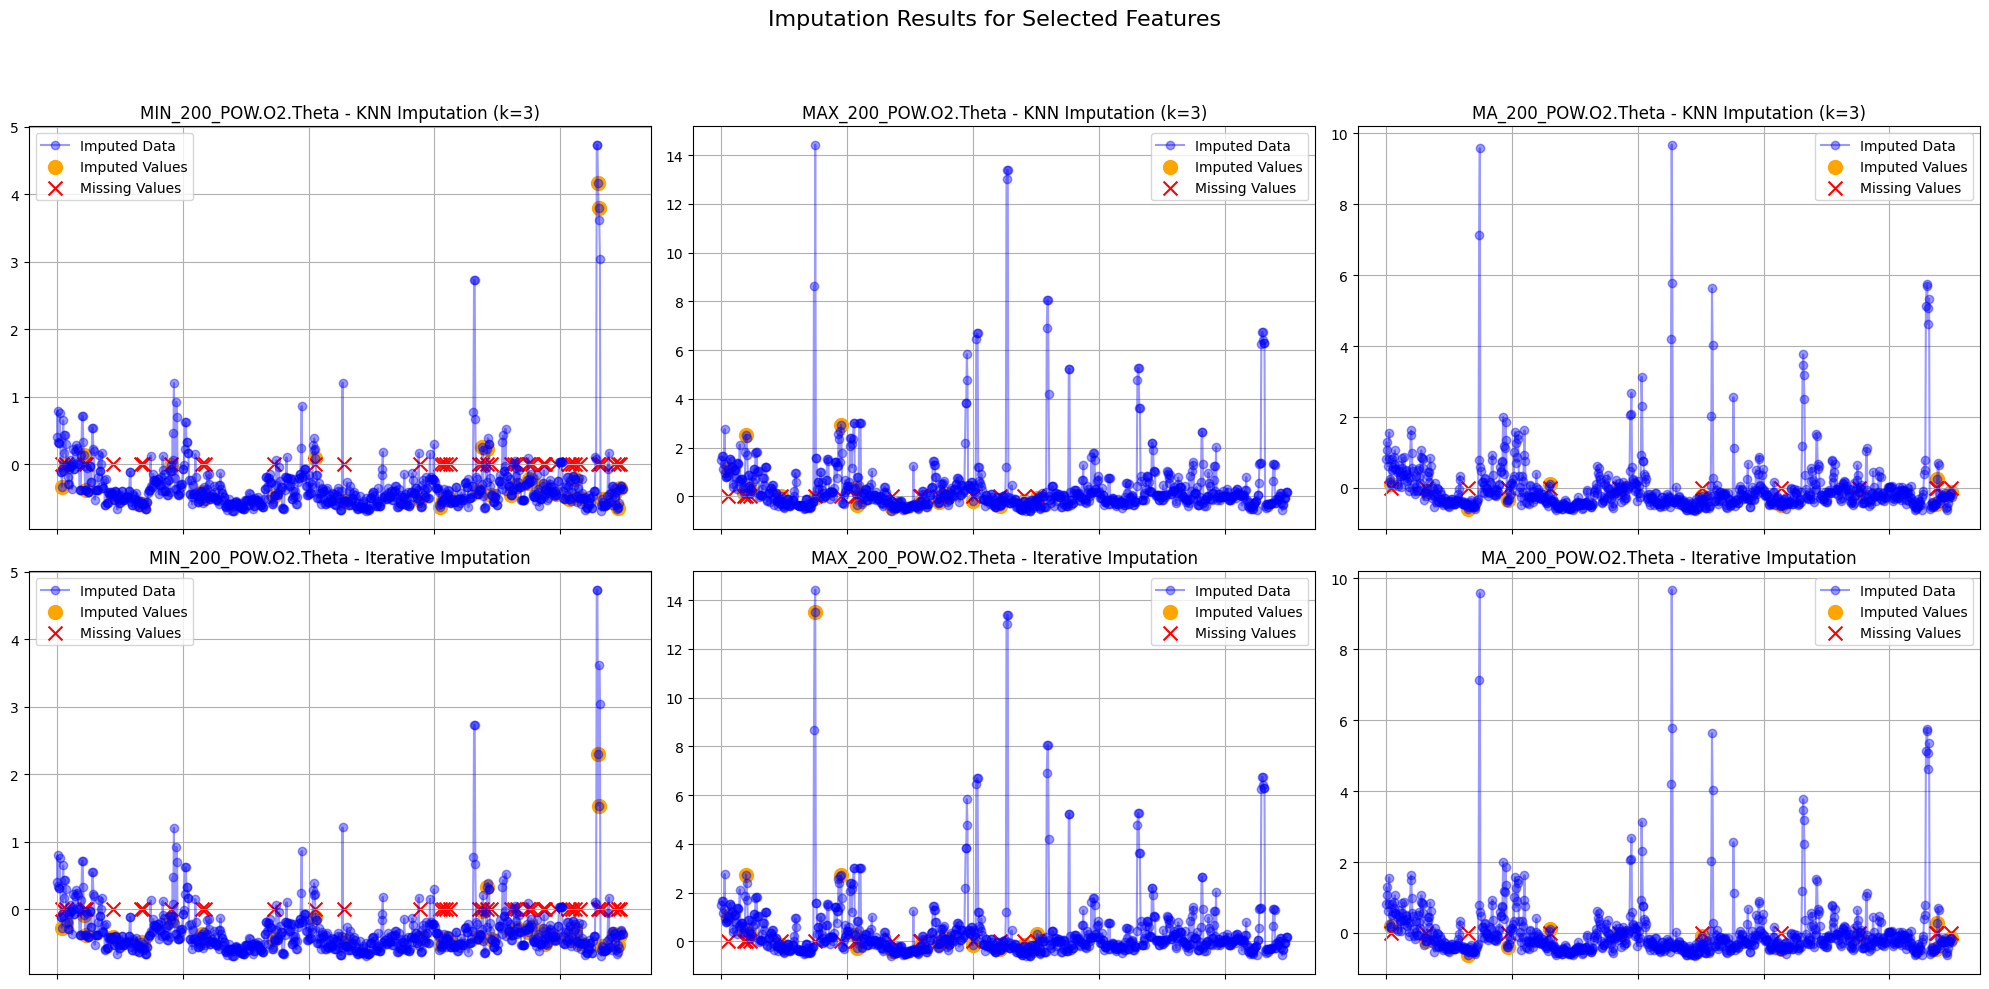

In [35]:
# --------------------------
# GÖRSELLEŞTİRME
# --------------------------
num_cols = 3
num_rows = (len(imputation_methods) * len(selected_cols)) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15), sharex=True, sharey=False)
axes = axes.flatten()

i = 0
for method_name, imputed_df in imputation_methods.items():
    for col in selected_cols:
        missing_indices = dff[dff[col].isnull()].index
        
        axes[i].plot(dff.index, imputed_df[col], 'bo-', alpha=0.4, label="Imputed Data")
        axes[i].scatter(missing_indices, imputed_df.loc[missing_indices, col], color="orange", marker="o", s=100, label="Imputed Values")
        axes[i].scatter(missing_indices, [0]*len(missing_indices), color="red", marker="x", s=100, label="Missing Values")
        axes[i].set_title(f"{col} - {method_name}")
        axes[i].legend()
        axes[i].grid()
        i += 1

# Gereksiz subplotları sil
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Imputation Results for Selected Features", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [38]:
# Filling with KNN Imputer (k=3)
knn_imputer = KNNImputer(n_neighbors=3)
knn_imputed = pd.DataFrame(knn_imputer.fit_transform(subset), columns=selected_cols, index=subset.index)
dff[selected_cols] = knn_imputed
na_columns = missing_values_table(dff, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


#  feature selection

In [43]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'ESRB' column
le_esrb = LabelEncoder()
dff["ESRB"] = le_esrb.fit_transform(dff["ESRB"])

# Check the data types again after encoding
print(dff["ESRB"].unique())
print(dff["PEGI"].unique())

[2 1 0]
[12 18 16  3  7]


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Separate input features (X) and target variable (y)
target_columns = ["ESRB","PEGI"]
X = dff.drop(columns=target_columns)  # replace with your actual target column name
y = dff[target_columns]

# Train MultiOutputClassifier
model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X, y)

# Get feature importances for each output
importances = [est.feature_importances_ for est in model.estimators_]

# Convert to DataFrame
importances_df = pd.DataFrame(importances, columns=X.columns, index=target_columns)

# Add a row for Mean_Importance to calculate the average importance across both targets
importances_df.loc["Mean_Importance"] = importances_df.mean(axis=0)

# Sort the features by their mean importance (average importance across both targets)
top_features = importances_df.T.sort_values("Mean_Importance", ascending=False)

# Print the top features along with their importance for both targets and the average importance
print(top_features.head(10))

                           ESRB      PEGI  Mean_Importance
RMS_200_POW.AF3.Gamma  0.002914  0.001823         0.002368
MIN_100_POW.AF3.Gamma  0.002754  0.001099         0.001927
MAX_200_POW.AF4.Gamma  0.002289  0.001252         0.001770
MIN_200_POW.F3.Theta   0.001615  0.001741         0.001678
MAX_200_POW.AF3.Gamma  0.002142  0.001110         0.001626
MIN_50_POW.AF3.Gamma   0.002493  0.000672         0.001583
MA_200_POW.AF4.Theta   0.000508  0.002403         0.001455
MIN_200_POW.T7.Alpha   0.001417  0.001486         0.001451
MIN_200_POW.AF3.Gamma  0.001936  0.000836         0.001386
MIN_200_POW.O2.Theta   0.001735  0.001002         0.001368


Text(0, 0.5, 'Features')

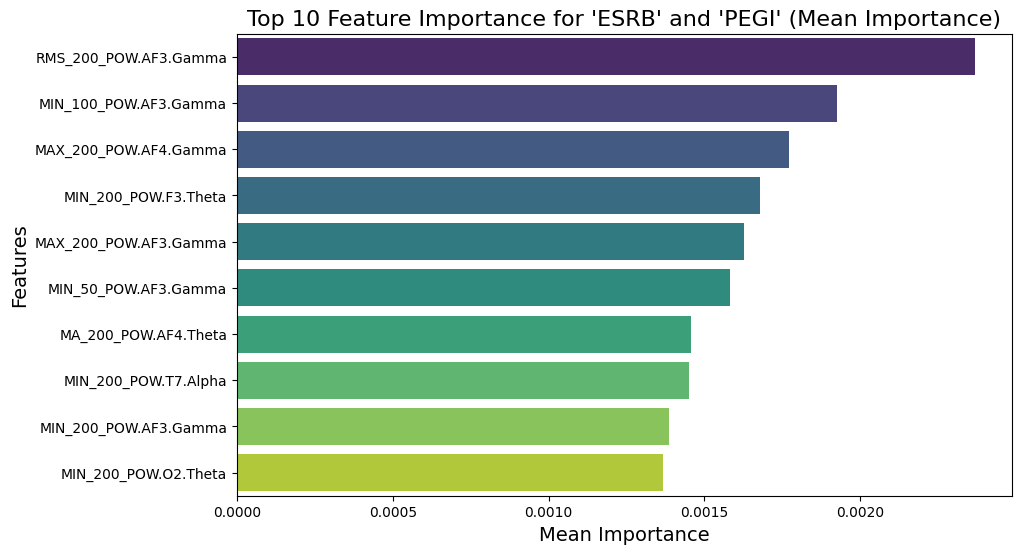

In [65]:
top_features_10 = top_features.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features_10['Mean_Importance'], y=top_features_10.index, palette="viridis", hue=top_features_10.index)
plt.title("Top 10 Feature Importance for 'ESRB' and 'PEGI' (Mean Importance)", fontsize=16)
plt.xlabel("Mean Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)

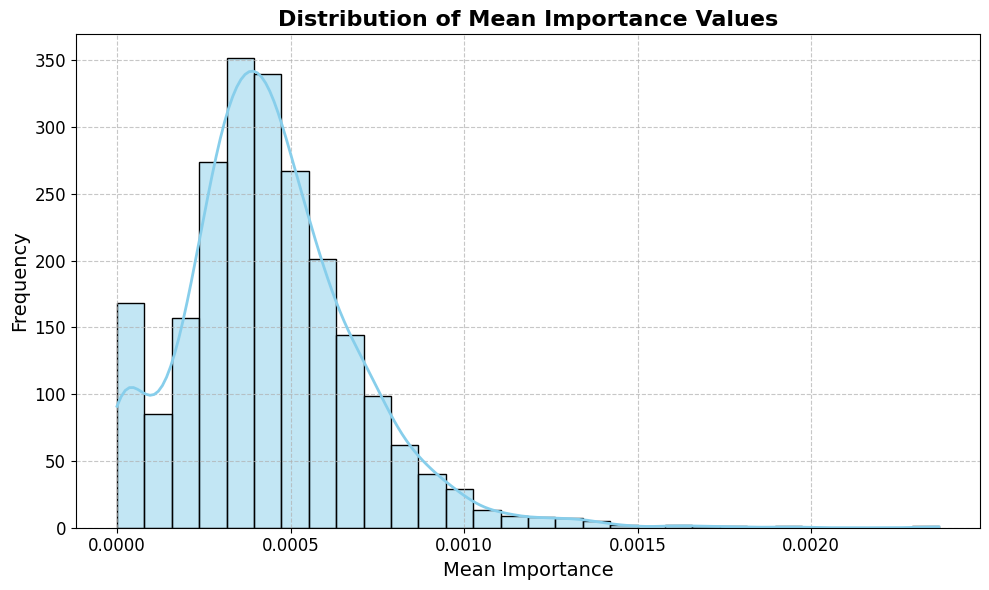

In [75]:
# Histogram with KDE for Mean Importance
plt.figure(figsize=(10, 6))
sns.histplot(top_features['Mean_Importance'], kde=True, bins=30, color='skyblue', line_kws={'color': 'red', 'lw': 2})
plt.title("Distribution of Mean Importance Values", fontsize=16, fontweight='bold')
plt.xlabel("Mean Importance", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [76]:
print(top_features['Mean_Importance'].describe())

count    2268.000000
mean        0.000441
std         0.000252
min         0.000000
25%         0.000286
50%         0.000416
75%         0.000572
max         0.002368
Name: Mean_Importance, dtype: float64


In [83]:
#Select features with importance greater than 0.05
important_features = top_features[top_features['Mean_Importance'] > 0.0005]
important_feature_columns = important_features.index
print(important_feature_columns)

Index(['RMS_200_POW.AF3.Gamma', 'MIN_100_POW.AF3.Gamma',
       'MAX_200_POW.AF4.Gamma', 'MIN_200_POW.F3.Theta',
       'MAX_200_POW.AF3.Gamma', 'MIN_50_POW.AF3.Gamma', 'MA_200_POW.AF4.Theta',
       'MIN_200_POW.T7.Alpha', 'MIN_200_POW.AF3.Gamma', 'MIN_200_POW.O2.Theta',
       ...
       'MAX_50_POW.T8.Alpha', 'CrestFactor_50_EEG.FC5', 'MA_50_POW.P8.BetaL',
       'CrestFactor_200_EEG.FC5', 'STD_100_POW.AF3.Alpha',
       'RMS_200_POW.FC6.Gamma', 'MIN_50_POW.AF4.Gamma', 'RMS_100_POW.T8.Alpha',
       'MA_100_POW.F3.Theta', 'CrestFactor_100_POW.O1.BetaL'],
      dtype='object', length=789)


# Machine Learning, Evaluation & Model Selection

In [84]:
# Function to evaluate different models and parameter configurations
def evaluate_models(X_train, X_test, y_train, y_test, models):
    """
    This function trains each model with different parameter settings
    and returns evaluation metrics and the best model based on accuracy.
    """
    results = []
    best_overall = {"model_name": None, "config": None, "accuracy": 0, "estimator": None}

    # Loop through each model and parameter configuration
    for model_name, model_info in models.items():
        base_estimator = model_info["estimator"]
        
        for param_config in model_info["params"]:
            # Set hyperparameters
            estimator = base_estimator.set_params(**param_config)
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)
            
            # Compute evaluation metrics
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            rec = recall_score(y_test, y_pred, average='weighted')
             
            # Save the results
            results.append({
                "Model": model_name,
                "Parameters": str(param_config),
                "Accuracy": acc,
                "F1": f1,
                "Precision": prec,
                "Recall": rec,
            })
            
            # Track the best model based on accuracy
            if acc > best_overall["accuracy"]:
                best_overall.update({
                    "model_name": model_name,
                    "config": param_config,
                    "accuracy": acc,
                    "estimator": estimator
                })
    
    return results, best_overall

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
models = {
    "DecisionTree": {
        "estimator": DecisionTreeClassifier(random_state=42),
        "params": [
            {"max_depth": 3},
            {"max_depth": 5},
            {"max_depth": None}
        ]
    },
    "KNN": {
        "estimator": KNeighborsClassifier(),
        "params": [
            {"n_neighbors": 3},
            {"n_neighbors": 5},
            {"n_neighbors": 7}
        ]
    },
    "RandomForest": {
        "estimator": RandomForestClassifier(random_state=42),
        "params": [
            {"n_estimators": 50},
            {"n_estimators": 100},
            {"n_estimators": 200}
        ]
    },
    "MLP": {
        "estimator": MLPClassifier(max_iter=300, random_state=42),
        "params": [
            {"hidden_layer_sizes": (50,)},
            {"hidden_layer_sizes": (100,)},
            {"hidden_layer_sizes": (50, 50)}
        ]
    },
    "SVC": {
        "estimator": SVC(probability=True, random_state=42),
        "params": [
            {"C": 0.1, "kernel": "rbf", "gamma": "scale"},
            {"C": 1, "kernel": "rbf", "gamma": "scale"},
            {"C": 10, "kernel": "rbf", "gamma": "scale"}
        ]
    }
}

In [96]:
def evaluate_for_targets(df, target_list, models, important_feature_columns=None):
    """
    This function loops over each target variable, splits and scales the data,
    evaluates all models, and stores the results.
    """
    all_results = {}

    # Use selected features if provided, otherwise use all features
    if important_feature_columns is not None:
        X = df[important_feature_columns]
    else:
        X = df.drop(columns=target_list)

    for target in target_list:
        print(f"\n--- Evaluating Target: {target} ---")
        
        # Prepare labels (y) for the current target
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Train and evaluate models
        results, best = evaluate_models(X_train, X_test, y_train, y_test, models)
        
        # Store results
        all_results[target] = {
            "all": results,
            "best": best
        }
        for result in results:
            print(result)

        print("\nBest model for", target)
        print(best)

    return all_results


In [99]:
model_results = evaluate_for_targets(dff, ["ESRB", "PEGI"], models,important_feature_columns)


--- Evaluating Target: ESRB ---
{'Model': 'DecisionTree', 'Parameters': "{'max_depth': 3}", 'Accuracy': 0.6111111111111112, 'F1': 0.5289451255226482, 'Precision': 0.6020190962719699, 'Recall': 0.6111111111111112}
{'Model': 'DecisionTree', 'Parameters': "{'max_depth': 5}", 'Accuracy': 0.5962962962962963, 'F1': 0.551556164582017, 'Precision': 0.539989636607994, 'Recall': 0.5962962962962963}
{'Model': 'DecisionTree', 'Parameters': "{'max_depth': None}", 'Accuracy': 0.5925925925925926, 'F1': 0.5905462892575534, 'Precision': 0.5889651861653545, 'Recall': 0.5925925925925926}
{'Model': 'KNN', 'Parameters': "{'n_neighbors': 3}", 'Accuracy': 0.7111111111111111, 'F1': 0.7020214957120922, 'Precision': 0.7273888479489069, 'Recall': 0.7111111111111111}
{'Model': 'KNN', 'Parameters': "{'n_neighbors': 5}", 'Accuracy': 0.6666666666666666, 'F1': 0.6488084714814334, 'Precision': 0.6627444112701485, 'Recall': 0.6666666666666666}
{'Model': 'KNN', 'Parameters': "{'n_neighbors': 7}", 'Accuracy': 0.68148148

# Visualize All Tried Results

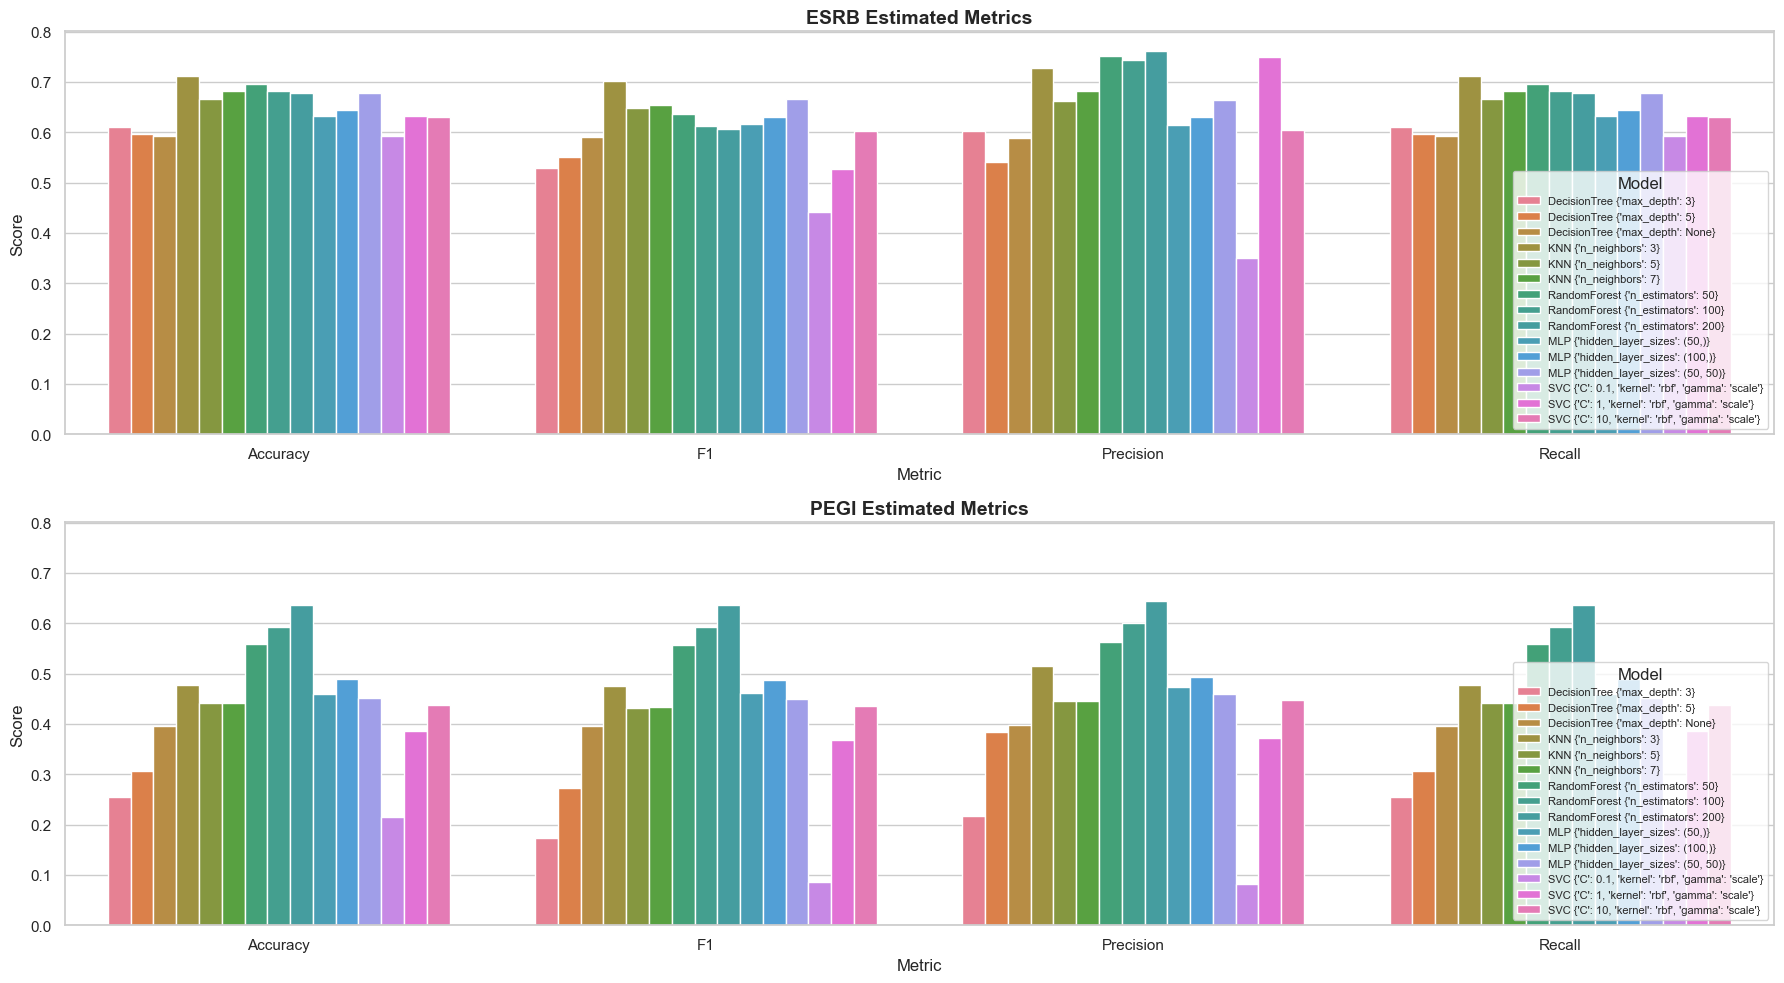

In [110]:
results = model_results
def prepare_df(data, label):
    df = pd.DataFrame(data["all"])
    df["ModelName"] = df["Model"] + " " + df["Parameters"]
    df["Label"] = label
    return df[["ModelName", "Accuracy", "F1", "Precision", "Recall", "Label"]]

esrb_df = prepare_df(results["ESRB"], "ESRB")
pegi_df = prepare_df(results["PEGI"], "PEGI")

esrb_melted = pd.melt(esrb_df, id_vars=["ModelName"], value_vars=["Accuracy", "F1", "Precision", "Recall"],
                      var_name="Metric", value_name="Value")
pegi_melted = pd.melt(pegi_df, id_vars=["ModelName"], value_vars=["Accuracy", "F1", "Precision", "Recall"],
                      var_name="Metric", value_name="Value")

sns.set_theme(style="whitegrid")
palette = sns.color_palette("husl", len(esrb_df["ModelName"].unique()))
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharey=True)

# ESRB
sns.barplot(data=esrb_melted, x="Metric", y="Value", hue="ModelName", palette=palette, ax=axes[0])
axes[0].set_title("ESRB Estimated Metrics", fontsize=14,fontweight='bold')
axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Score")
axes[0].legend(title="Model", loc="lower right", fontsize=8)

# PEGI
sns.barplot(data=pegi_melted, x="Metric", y="Value", hue="ModelName", palette=palette, ax=axes[1])
axes[1].set_title("PEGI Estimated Metrics", fontsize=14,fontweight='bold')
axes[1].set_xlabel("Metric")
axes[1].set_ylabel("Score")
axes[1].legend(title="Model", loc="lower right", fontsize=8)

plt.tight_layout()
plt.show()

# Best Model Performance & Parameters

In [121]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def hyperparameter_tuning(df, target, model_name, important_feature_columns=None):
    """
    This function performs hyperparameter tuning using GridSearchCV
    based on the given model name and target variable.
    """
    # Prepare the features (X) and labels (y) for training
    if important_feature_columns is not None:
        X = df[important_feature_columns]
    else:
        X = df.drop(columns=target)
        
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Scaling the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the grid and estimator based on model_name
    if model_name == "RandomForest":
        grid = {
            "n_estimators": [100, 200, 300],  # Number of trees in the forest
            "max_depth": [None, 15, 20],  # Maximum depth of the trees
            "min_samples_split": [2, 4, 6],  # Minimum samples required to split an internal node
            "min_samples_leaf": [1, 2],
            "max_features": ['sqrt', 'log2']
        }
        estimator = RandomForestClassifier(random_state=42)
            
    elif model_name == "KNN":
        grid = {
            "n_neighbors": [1, 3, 5, 7, 9],  # Number of neighbors to use
            "weights": ['uniform', 'distance'],  # Weight function for prediction
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm to compute nearest neighbors
            "leaf_size": [20, 30, 40],  # Leaf size for tree-based algorithms
            "p": [1, 2]  # Minkowski distance parameter (1 = Manhattan, 2 = Euclidean)
        }
        estimator = KNeighborsClassifier()
    
    else:
        raise ValueError(f"Model '{model_name}' is not supported for hyperparameter tuning.")

    # Perform Grid Search with cross-validation
    print(f"\nPerforming Grid Search for {model_name} with parameters:", grid)
    grid_search = GridSearchCV(estimator, grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("\nGrid Search Results:")
    print("Best parameters:", grid_search.best_params_)
    print("Best CV Accuracy:", grid_search.best_score_)

    # Return the best model, its parameters, and best cross-validation score
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_, X_test, y_test

In [131]:
# Model Name and Hyperparameter Tuning
model_name = "KNN"
best_model_ESRB, best_params_ESRB, best_score_ESRB, X_test_ESRB, y_test_ESRB = hyperparameter_tuning(
    dff, "ESRB", model_name, important_feature_columns)

# Test the best model on the test data
y_pred_ESRB = best_model_ESRB.predict(X_test_ESRB)
test_acc_ESRB = accuracy_score(y_test_ESRB, y_pred_ESRB)
print(f"Test Accuracy with Best Model ESRB: {test_acc_ESRB}")


Performing Grid Search for KNN with parameters: {'n_neighbors': [1, 3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [20, 30, 40], 'p': [1, 2]}

Grid Search Results:
Best parameters: {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best CV Accuracy: 0.8412698412698413
Test Accuracy with Best Model ESRB: 0.8481481481481481


In [122]:
# Model Name and Hyperparameter Tuning
model_name = "RandomForest"  # You can choose any model here
best_model, best_params, best_score, X_test, y_test = hyperparameter_tuning(dff, "PEGI", model_name, important_feature_columns)

# Test the best model on the test data
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Best Model: {test_acc}")


Performing Grid Search for RandomForest with parameters: {'n_estimators': [100, 200, 300], 'max_depth': [None, 15, 20], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2], 'max_features': ['sqrt', 'log2']}

Grid Search Results:
Best parameters: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
Best CV Accuracy: 0.6555555555555554
Test Accuracy with Best Model: 0.6666666666666666


# Testing with Test Data & Showing Predictions

In [148]:
from sklearn.metrics import classification_report
# --- Testing and Prediction for the ESRB Model ---
print("\n🔍 ESRB Model Results")
print("ESRB Classification Report")
print(classification_report(y_test_ESRB, y_pred_ESRB))

print("\n🔎 ESRB Sample Predictions")
print("First 5 Predictions vs True Values (ESRB):")
for i in range(5):
    print(f"True: {y_test_ESRB.iloc[i]}  →  Predicted: {y_pred_ESRB[i]}")


🔍 ESRB Model Results
ESRB Classification Report
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        56
           1       0.85      0.81      0.83        54
           2       0.86      0.92      0.89       160

    accuracy                           0.85       270
   macro avg       0.84      0.80      0.82       270
weighted avg       0.85      0.85      0.85       270


🔎 ESRB Sample Predictions
First 5 Predictions vs True Values (ESRB):
True: 0  →  Predicted: 0
True: 2  →  Predicted: 2
True: 1  →  Predicted: 1
True: 2  →  Predicted: 2
True: 0  →  Predicted: 0


In [149]:
# --- Testing and Prediction for the PEGI Model ---
print("\n🔍 PEGI Model Results")
print("ESRB Classification Report")
print(classification_report(y_test, y_pred))

print("\n🔎 PEGI Sample Predictions")
print("First 5 Predictions vs True Values (PEGI):")
for i in range(5):
    print(f"True: {y_test.iloc[i]}  →  Predicted: {y_pred[i]}")


🔍 PEGI Model Results
ESRB Classification Report
              precision    recall  f1-score   support

           3       0.82      0.59      0.69        56
           7       0.68      0.83      0.75        54
          12       0.65      0.58      0.61        52
          16       0.55      0.72      0.62        54
          18       0.70      0.61      0.65        54

    accuracy                           0.67       270
   macro avg       0.68      0.67      0.67       270
weighted avg       0.68      0.67      0.67       270


🔎 PEGI Sample Predictions
First 5 Predictions vs True Values (PEGI):
True: 7  →  Predicted: 7
True: 12  →  Predicted: 12
True: 18  →  Predicted: 16
True: 12  →  Predicted: 12
True: 3  →  Predicted: 3


# Saving the Model

In [141]:
# Save the best model to a file
joblib.dump(best_model, "04_best_model.pkl")
print(" Model saved as '04_best_model.pkl'")

 Model saved as '04_best_model.pkl'


# Model Deployment

In [142]:
# Later or in production: Load the model from the file
loaded_model = joblib.load("04_best_model.pkl")
print(" Model successfully loaded from '04_best_model.pkl'")

 Model successfully loaded from '04_best_model.pkl'
